In [2]:
# tratamiento de datos
import pandas as pd
import numpy as np

# visualizaciones
import matplotlib.pyplot as plt
import seaborn as sns

#regresion
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

#configuracion de ruta
import sys
sys.path.append('../SRC')

from soporte import grafico_barras , graficar_ingresos , graficar_productos_recomprados, analizar_estacionalidad

In [3]:
df = pd.read_csv('../DATA/OUTPUT/cscpopendata_limpio.csv')

In [4]:
df.head()

ProductName                    CSF  \
0  ULTRA COLOR RICH EXTRA PLUMP LIPSTICK-ALL SHADES  no_coloring/flavoring   
1                        Glover's Medicated Shampoo  no_coloring/flavoring   
2                        Glover's Medicated Shampoo  no_coloring/flavoring   
3          PRECISION GLIMMER EYE LINER-ALL SHADES ÔøΩ  no_coloring/flavoring   
4       AVON BRILLIANT SHINE LIP GLOSS-ALL SHADES ÔøΩ  no_coloring/flavoring   

           CompanyName BrandName                    PrimaryCategory  \
0         New Avon LLC      AVON    Makeup Products (non-permanent)   
1  J. Strickland & Co.  Glover's  Hair Care Products (non-coloring)   
2  J. Strickland & Co.  Glover's  Hair Care Products (non-coloring)   
3         New Avon LLC      AVON    Makeup Products (non-permanent)   
4         New Avon LLC      AVON    Makeup Products (non-permanent)   

                                  SubCategory   CasNumber  \
0  Lip Color - Lipsticks, Liners, and Pencils  13463-67-7   
1    Hair Shampoos (making a cosmetic claim)   65996-92-1   
2    Hair Shampoos (making a cosmetic claim)     140-67-0   
3                    Eyeliner/Eyebrow Pencils  13463-67-7   
4                             Lip Gloss/Shine  13463-67-7   

             ChemicalName InitialDateReported MostRecentDateReported  \
0        Titanium dioxide          2009-06-17             2013-08-28   
1  Distillates (coal tar)          2009-07-01             2009-07-01   
2               Estragole          2009-07-01             2009-07-01   
3        Titanium dioxide          2009-07-09             2013-08-28   
4        Titanium dioxide          2009-07-09             2013-08-28   

  DiscontinuedDate ChemicalCreatedAt ChemicalUpdatedAt ChemicalDateRemoved  \
0       2011-02-01        2009-07-09        2009-07-09                 NaN   
1              NaN        2009-07-01        2009-07-01                 NaN   
2              NaN        2009-07-02        2009-07-02                 NaN   
3              NaN        2009-07-09        2009-07-09                 NaN   
4       2011-02-01        2009-07-09        2009-07-09                 NaN   

   ChemicalCount  
0              1  
1              2  
2              2  
3              1  
4              1

## OBJETIVOS DEL ANALISIS
- Conocer que empresas reportan m√°s productos qu√≠micos
- Conocer cu√°les son las categor√≠as o subcategor√≠as m√°s frecuentes
- indentificar que productos qu√≠micos han sido eliminados con mayor frecuencia
- identificar la proporci√≥n de productos descontinuados o eliminados
- identificar si hay empresas que eliminan productos m√°s r√°pido que otras
- estimar el tiempo de vida de un producto quimico (regresion)
- Segmentar marcas por comportamiento: conservadoras vs innovadoras (pocas vs muchas eliminaciones)


/Users/eugecamperchioli/Desktop/BORRADORES DE CLASES/EDA_PROYECTOFINAL/NOTEBOOK/../SRC/soporte.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette=palette)


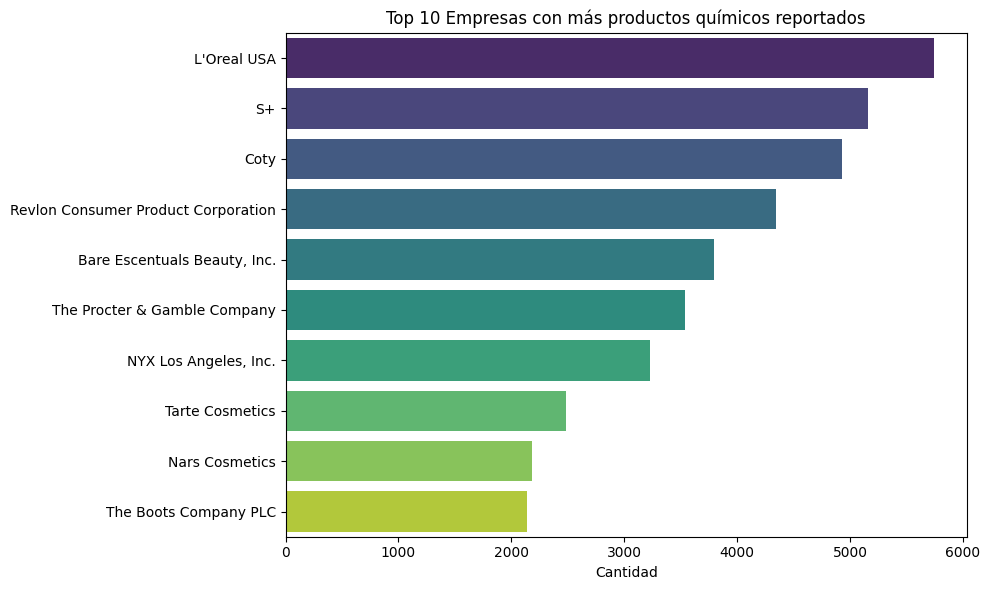

In [5]:
grafico_barras(df['CompanyName'], title='Top 10 Empresas con m√°s productos qu√≠micos reportados')

/Users/eugecamperchioli/Desktop/BORRADORES DE CLASES/EDA_PROYECTOFINAL/NOTEBOOK/../SRC/soporte.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette=palette)


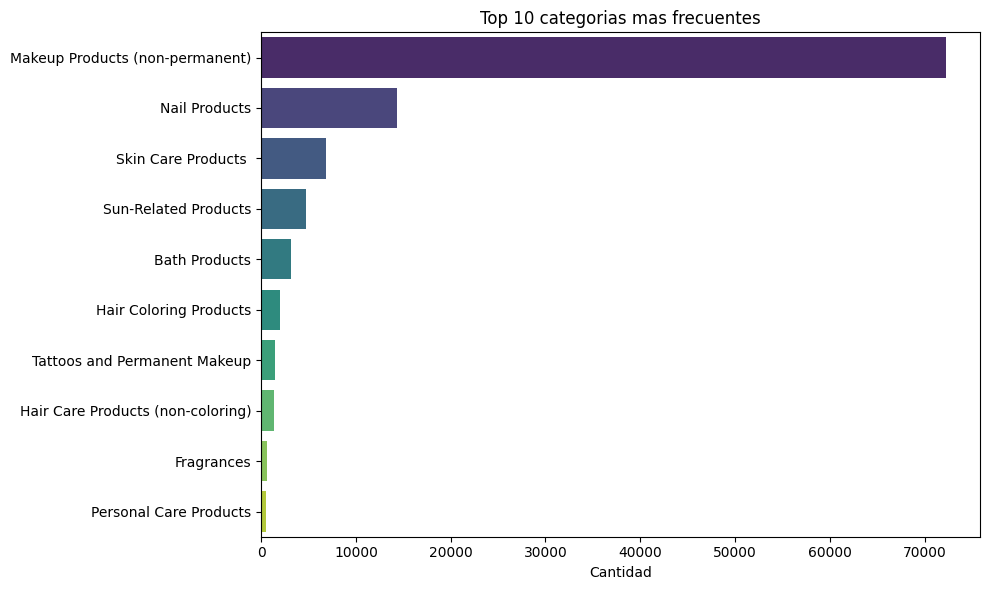

In [6]:
grafico_barras(df['PrimaryCategory'], title='Top 10 categorias mas frecuentes')


/Users/eugecamperchioli/Desktop/BORRADORES DE CLASES/EDA_PROYECTOFINAL/NOTEBOOK/../SRC/soporte.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette=palette)


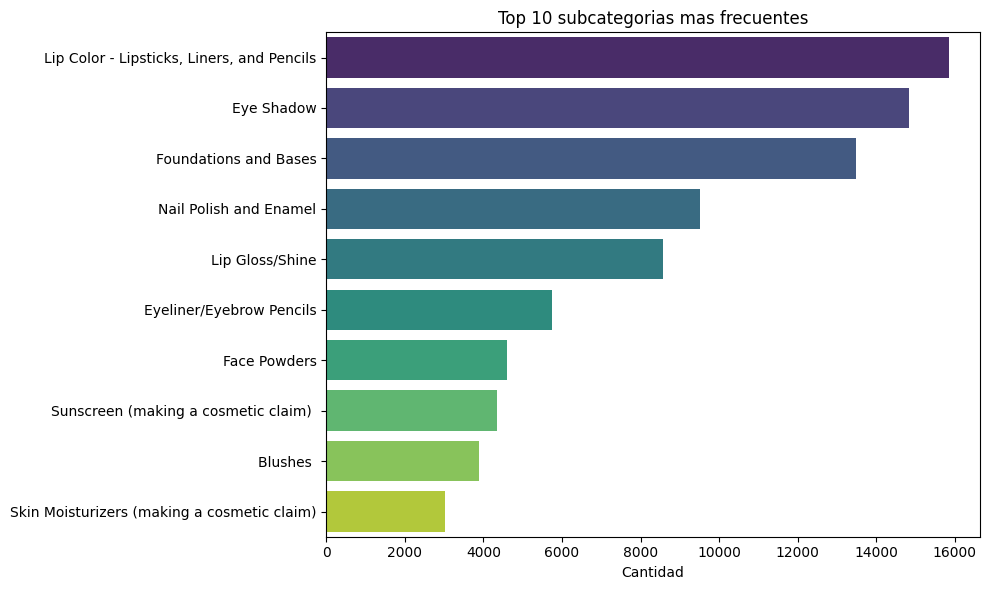

In [7]:
grafico_barras(df['SubCategory'], title='Top 10 subcategorias mas frecuentes')

/Users/eugecamperchioli/Desktop/BORRADORES DE CLASES/EDA_PROYECTOFINAL/NOTEBOOK/../SRC/soporte.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette=palette)


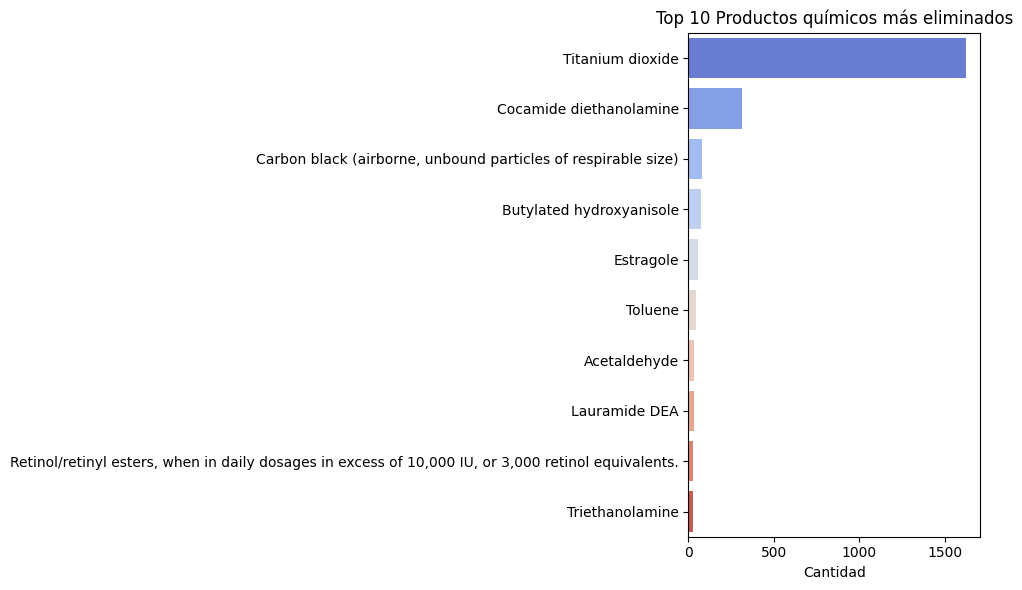

In [8]:
grafico_barras(df[df['ChemicalDateRemoved'].notna()]['ChemicalName'], 
                title='Top 10 Productos qu√≠micos m√°s eliminados', palette='coolwarm')


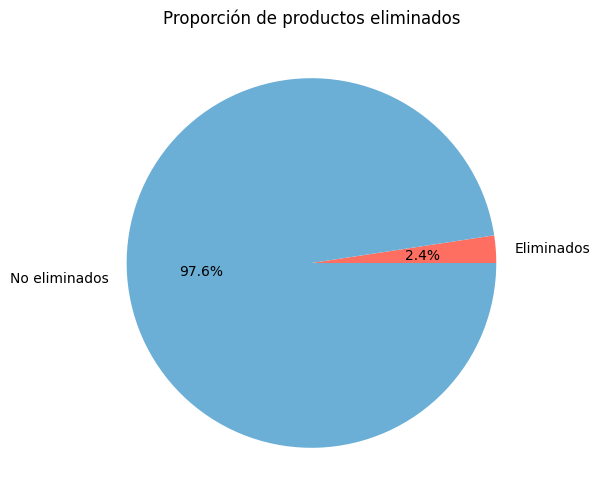

In [9]:
labels = ['Eliminados', 'No eliminados']
sizes = [df['ChemicalDateRemoved'].notna().sum(), df['ChemicalDateRemoved'].isna().sum()]

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['#ff6f61', '#6baed6'])
plt.title('Proporci√≥n de productos eliminados')
plt.show()

In [10]:
df['ChemicalDateRemoved'] = pd.to_datetime(df['ChemicalDateRemoved'], errors='coerce')
df['ChemicalCreatedAt'] = pd.to_datetime(df['ChemicalCreatedAt'], errors='coerce')

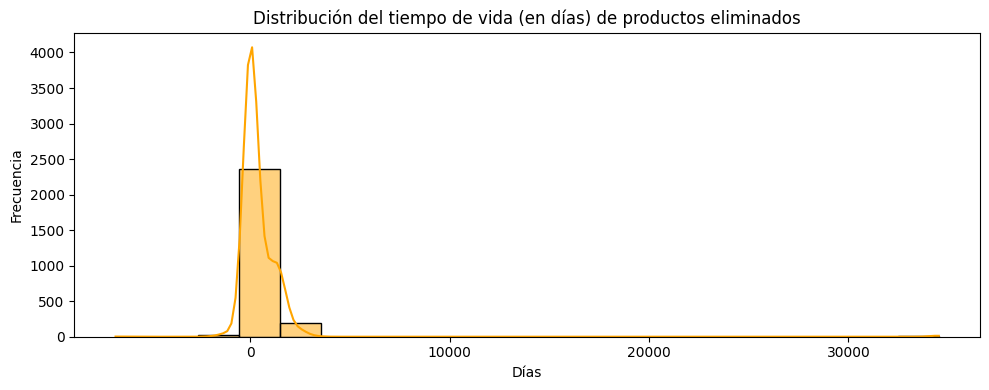

In [11]:
df_eliminados = df[df['ChemicalDateRemoved'].notna()].copy()
df_eliminados['tiempo_vida'] = (df_eliminados['ChemicalDateRemoved'] - df_eliminados['ChemicalCreatedAt']).dt.days

plt.figure(figsize=(10,4))
sns.histplot(df_eliminados['tiempo_vida'], bins=20, kde=True, color='orange')
plt.title('Distribuci√≥n del tiempo de vida (en d√≠as) de productos eliminados')
plt.xlabel('D√≠as')
plt.ylabel('Frecuencia')
plt.tight_layout()

/var/folders/tx/p7ygn4nx5y1b4pgmj1jv49g40000gn/T/ipykernel_74177/970990645.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_rapidas.values, y=top_rapidas.index, palette='crest')


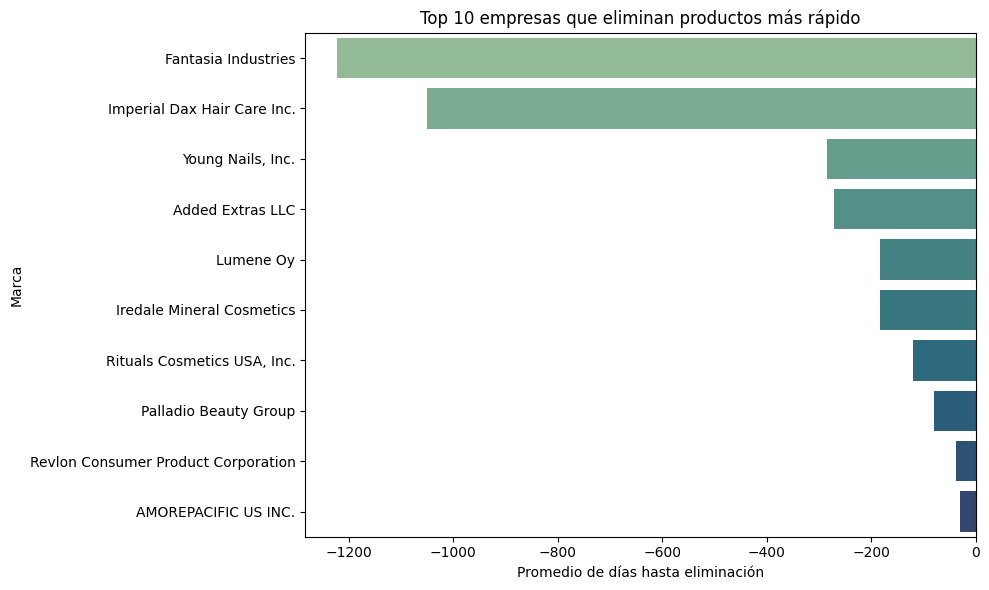

In [12]:
df_eliminados = df[df['ChemicalDateRemoved'].notna()].copy()
df_eliminados['tiempo_vida'] = (df_eliminados['ChemicalDateRemoved'] - df_eliminados['ChemicalCreatedAt']).dt.days

top_rapidas = df_eliminados.groupby('CompanyName')['tiempo_vida'].mean().sort_values().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_rapidas.values, y=top_rapidas.index, palette='crest')
plt.title('Top 10 empresas que eliminan productos m√°s r√°pido')
plt.xlabel('Promedio de d√≠as hasta eliminaci√≥n')
plt.ylabel('Marca')
plt.tight_layout()

In [13]:
fechas = ['ChemicalDateRemoved', 'ChemicalCreatedAt', 'InitialDateReported',
          'MostRecentDateReported', 'ChemicalUpdatedAt']
for col in fechas:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Filtrar solo productos eliminados
df_model = df[df['ChemicalDateRemoved'].notna()].copy()

# Calcular la variable objetivo
df_model['tiempo_vida'] = (df_model['ChemicalDateRemoved'] - df_model['ChemicalCreatedAt']).dt.days

df_model['dias_desde_reporte'] = (df_model['ChemicalCreatedAt'] - df_model['InitialDateReported']).dt.days
df_model['dias_ultima_actualizacion'] = (df_model['ChemicalUpdatedAt'] - df_model['ChemicalCreatedAt']).dt.days
df_model['a√±o_creacion'] = df_model['ChemicalCreatedAt'].dt.year
df_model['mes_creacion'] = df_model['ChemicalCreatedAt'].dt.month

features = [
    'CSF', 'CompanyName', 'BrandName', 'PrimaryCategory', 'SubCategory',
    'ChemicalName', 'ChemicalCount',
    'dias_desde_reporte', 'dias_ultima_actualizacion', 'a√±o_creacion', 'mes_creacion'
]

df_model = df_model[features + ['tiempo_vida']].dropna()

# One-hot encoding para variables categ√≥ricas
df_encoded = pd.get_dummies(df_model, drop_first=True)

X = df_encoded.drop('tiempo_vida', axis=1)
y = df_encoded['tiempo_vida']

# entrenar modelo de regresion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"üìâ MAE (Error Absoluto Medio): {mae:.2f} d√≠as")
print(f"üìà R¬≤ (Coeficiente de determinaci√≥n): {r2:.2f}")


üìâ MAE (Error Absoluto Medio): 166.64 d√≠as
üìà R¬≤ (Coeficiente de determinaci√≥n): 0.14


/var/folders/tx/p7ygn4nx5y1b4pgmj1jv49g40000gn/T/ipykernel_74177/2388516967.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=segmentacion, x='tipo_marca', palette='Set2')


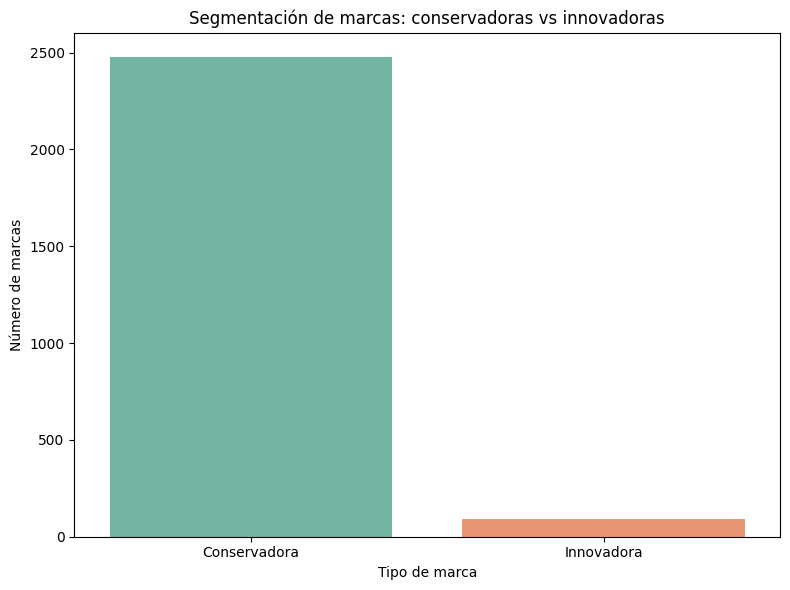

In [14]:
total_productos = df.groupby('BrandName').size()
eliminados_por_marca = df[df['ChemicalDateRemoved'].notna()].groupby('BrandName').size()
porcentaje_eliminado = (eliminados_por_marca / total_productos).fillna(0)

segmentacion = porcentaje_eliminado.reset_index()
segmentacion.columns = ['BrandName', 'porcentaje_eliminado']
segmentacion['tipo_marca'] = segmentacion['porcentaje_eliminado'].apply(
    lambda x: 'Innovadora' if x > 0.5 else 'Conservadora'
)

plt.figure(figsize=(8, 6))
sns.countplot(data=segmentacion, x='tipo_marca', palette='Set2')
plt.title('Segmentaci√≥n de marcas: conservadoras vs innovadoras')
plt.xlabel('Tipo de marca')
plt.ylabel('N√∫mero de marcas')
plt.tight_layout()


## CONCLUSIONES
- el top 5 de empresas con mas productos quimicos reportados es liderado por LOREAL y seguido por SEPHORA, COTY, REVLON Y BARE.
- el top 5 de categorias mas frecuentes es liderado por MAQUILLAJE y seguido por CUIDADO DE U√ëAS, CUIDADO DE LA PIEL, PRODUCTOS RELACIONADOS CON EL SOL Y CON EL BA√ëO.
- el top 5 de subcategorias mas frecuentes es liderado por LABIALES y seguido por SOMBRAS DE OJOS, BASES, ESMALTES, LIP GLOSS Y DELINEADORES DE OJOS.
- el producto quimico mas eliminado es el Dioxido de Titanio, hay mucha distancia en relacion a los demas productos eliminados. en segundo lugar con una cantidad mucho menor es la cocamida dietanolamina
- la proporcion de productos eliminados es muy baja, solo un 2.4% en la base que estamos estudiando
- las dos empresas que lideran la eliminacion de procutos son FANTASIA INSDUSTRIES E IMPERIAL DAX HAIR CARE.
- El modelo de regresion obtuvo un error absoluto medio (MAE) de 166 d√≠as, significa que en promedio se equivoca por unos 5‚Äì6 meses al predecir la vida √∫til de un producto. El coeficiente de determinaci√≥n (R¬≤) fue 0.14, lo que indica que el modelo explica aproximadamente el 14% de la variabilidad en los tiempos de eliminaci√≥n. esto lo utilizamos para estimar cu√°ntos d√≠as vive un producto qu√≠mico antes de ser eliminado del mercado, en funci√≥n de sus caracter√≠sticas.
- podemos deducir que las marcas en general son mas conservadoras que innovadoras al no realizar muchas cambios en sus formulaciones

# UNIMOS NUESTRO DF CON INFORMACION DE VENTAS DE ECOMMERCE


In [15]:
df_ecom = pd.read_csv('../DATA/RAW/2020-Jan.csv')

In [16]:
df_ecom.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')

In [17]:
df.columns

Index(['ProductName', 'CSF', 'CompanyName', 'BrandName', 'PrimaryCategory',
       'SubCategory', 'CasNumber', 'ChemicalName', 'InitialDateReported',
       'MostRecentDateReported', 'DiscontinuedDate', 'ChemicalCreatedAt',
       'ChemicalUpdatedAt', 'ChemicalDateRemoved', 'ChemicalCount'],
      dtype='object')

# unificamos el nombre de la columna brand para hacer la fusion
el objetivo al unir estos datasets es cruzar nuestra informacion con la venta real de ecommerce para conocer los productos mas valorados por los consumidores

In [18]:
df['BrandName_clean'] = df['BrandName'].str.lower().str.strip()

df_ecom['brand_clean'] = df_ecom['brand'].str.lower().str.strip()


In [19]:
df_purchase = df_ecom[df_ecom['event_type'] == 'purchase']

df_merged = pd.merge(
    df,
    df_purchase,
    how='inner',
    left_on='BrandName_clean',
    right_on='brand_clean')

In [20]:
df_merged.shape

(734307, 26)

In [21]:
df_merged.columns

Index(['ProductName', 'CSF', 'CompanyName', 'BrandName', 'PrimaryCategory',
       'SubCategory', 'CasNumber', 'ChemicalName', 'InitialDateReported',
       'MostRecentDateReported', 'DiscontinuedDate', 'ChemicalCreatedAt',
       'ChemicalUpdatedAt', 'ChemicalDateRemoved', 'ChemicalCount',
       'BrandName_clean', 'event_time', 'event_type', 'product_id',
       'category_id', 'category_code', 'brand', 'price', 'user_id',
       'user_session', 'brand_clean'],
      dtype='object')

## tipo de datos
- Datos del producto qu√≠mico (ProductName, ChemicalName)
- Datos de eventos de compra (event_time, event_type, user_id, price)
- Datos de usuario y sesi√≥n (user_id, user_session)
- Datos limpios y categorizados (BrandName_clean, brand_clean, category_code)

## objetivo del analisis
- identificar marcas con mayor volumen de compra
- determinar evolucion temporal del gasto
- identificar el precio promedio por categoria
- identificar las marcas que generan m√°s ingreso totales
- identificar los productos que son recomprados frecuentemente por los mismos usuarios
- determinar si existen patrones de consumo por estaci√≥n/fecha


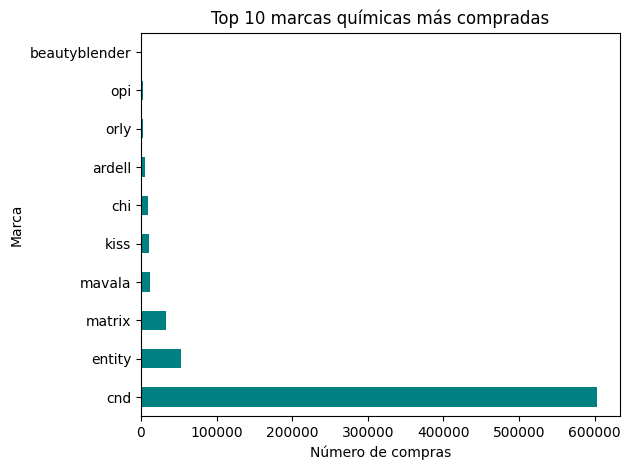

In [22]:
df_ventas = df_merged[df_merged['event_type'] == 'purchase']

top_marcas = df_ventas['BrandName_clean'].value_counts().head(10)

top_marcas.plot(kind='barh', color='teal')
plt.title('Top 10 marcas qu√≠micas m√°s compradas')
plt.xlabel('N√∫mero de compras')
plt.ylabel('Marca')
plt.tight_layout()

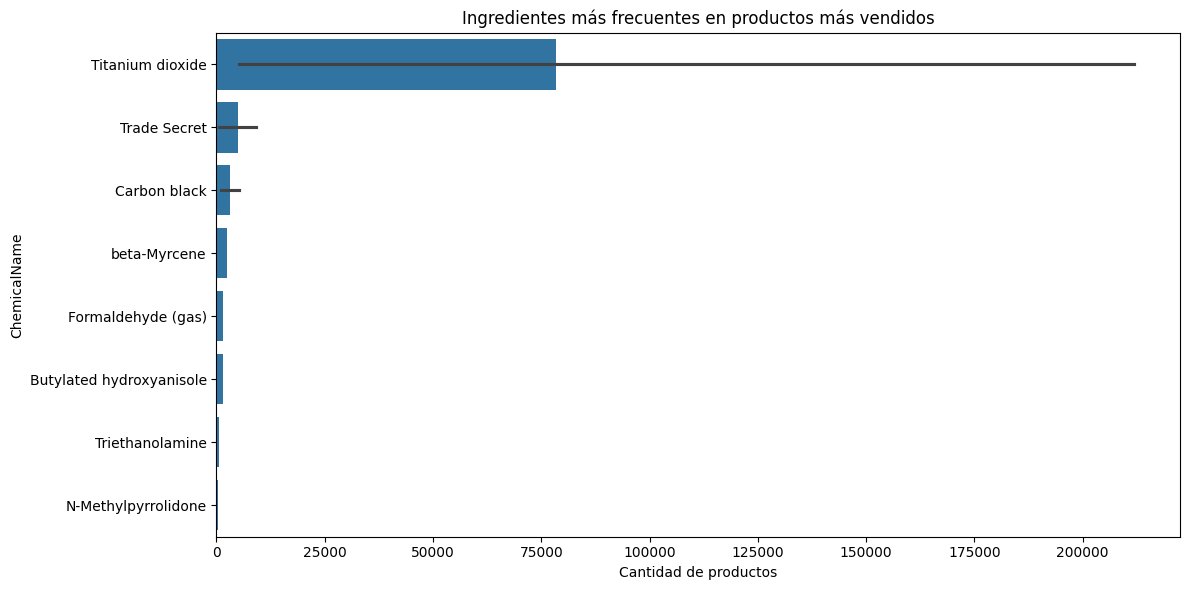

In [23]:
ingredientes = df_ventas.groupby(['BrandName_clean', 'ChemicalName'])['product_id'].count().reset_index()
ingredientes = ingredientes.sort_values(by='product_id', ascending=False).head(20)

plt.figure(figsize=(12,6))
sns.barplot(data=ingredientes, y='ChemicalName', x='product_id')
plt.title('Ingredientes m√°s frecuentes en productos m√°s vendidos')
plt.xlabel('Cantidad de productos')
plt.tight_layout()

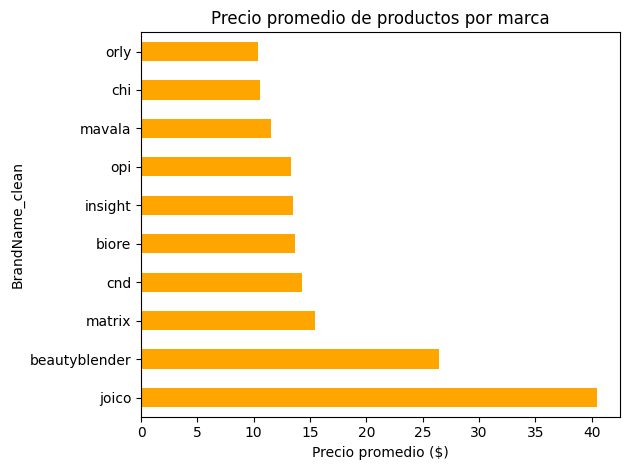

In [24]:
precios_marca = df_ventas.groupby('BrandName_clean')['price'].mean().sort_values(ascending=False).head(10)

precios_marca.plot(kind='barh', color='orange')
plt.title('Precio promedio de productos por marca')
plt.xlabel('Precio promedio ($)')
plt.tight_layout()

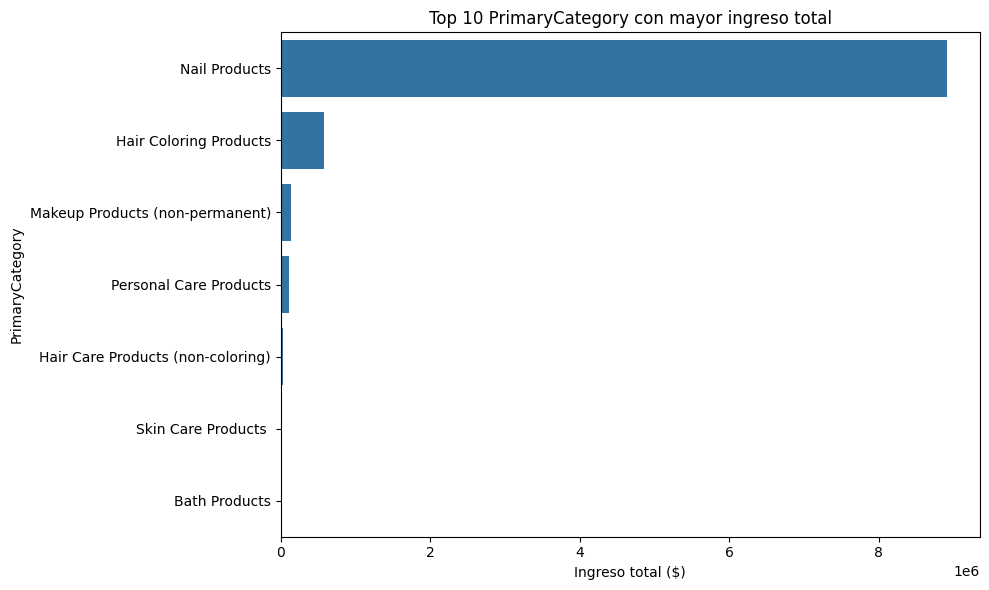

In [25]:
graficar_ingresos(df_merged, 'PrimaryCategory')

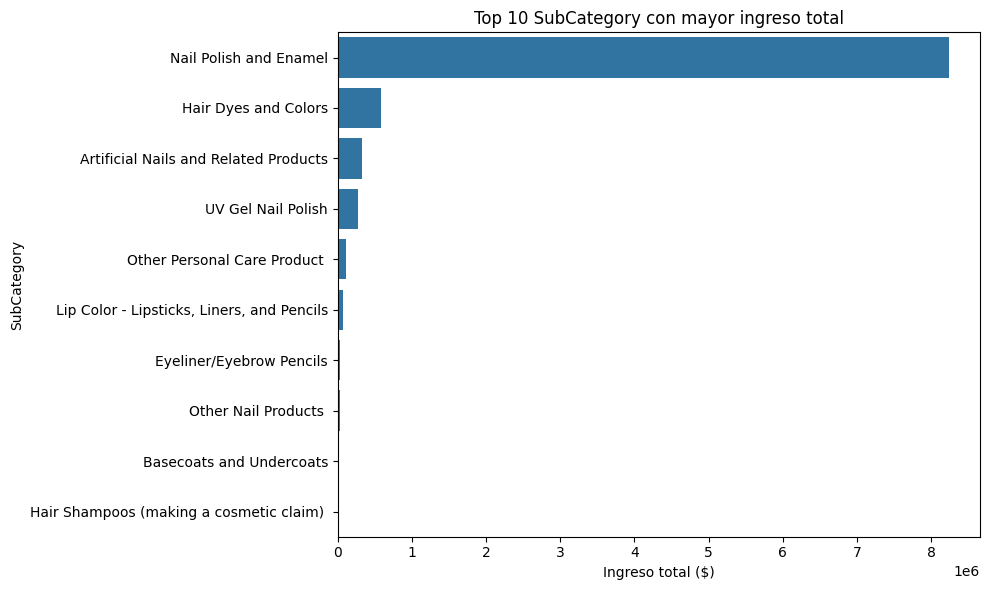

In [26]:
graficar_ingresos(df_merged, 'SubCategory')


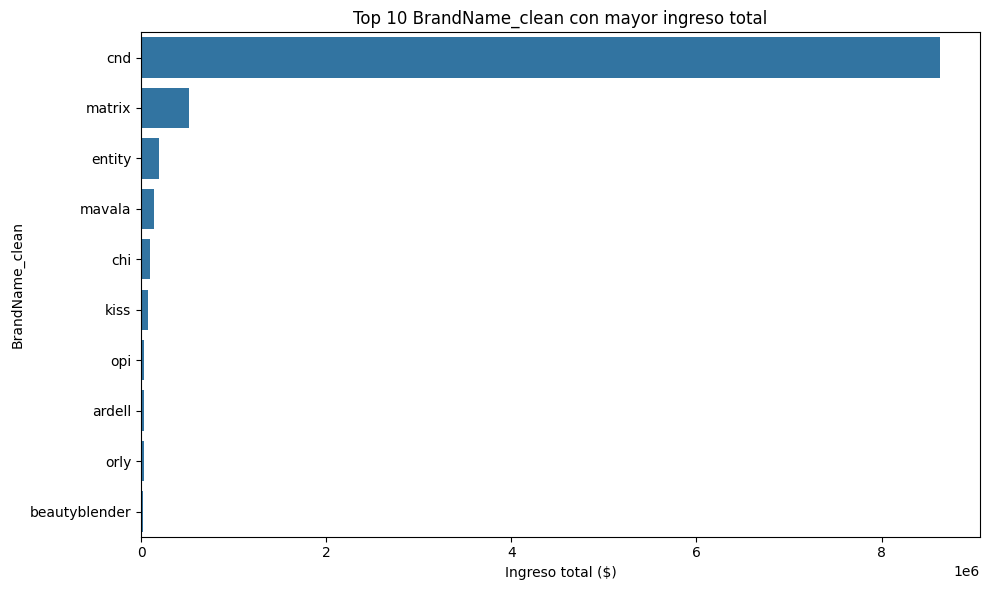

In [27]:
graficar_ingresos(df_merged, 'BrandName_clean', top_n=10)

/Users/eugecamperchioli/Desktop/BORRADORES DE CLASES/EDA_PROYECTOFINAL/NOTEBOOK/../SRC/soporte.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_resultado,


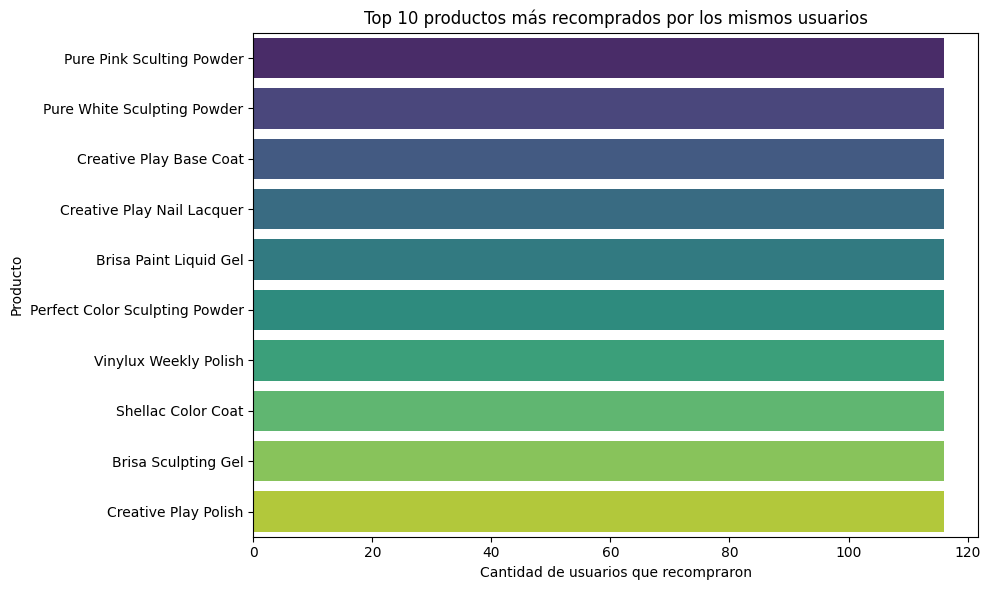

In [28]:
top_recompras = graficar_productos_recomprados(df_merged, top_n=10)

/Users/eugecamperchioli/Desktop/BORRADORES DE CLASES/EDA_PROYECTOFINAL/NOTEBOOK/../SRC/soporte.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_compras, x='dia_semana', order=orden_dias,palette='viridis')
/Users/eugecamperchioli/Desktop/BORRADORES DE CLASES/EDA_PROYECTOFINAL/NOTEBOOK/../SRC/soporte.py:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_compras, x='hora', palette='cubehelix')


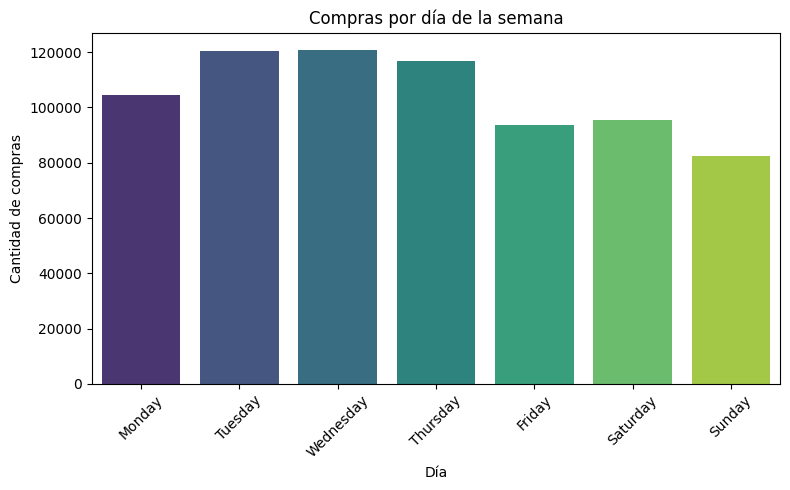

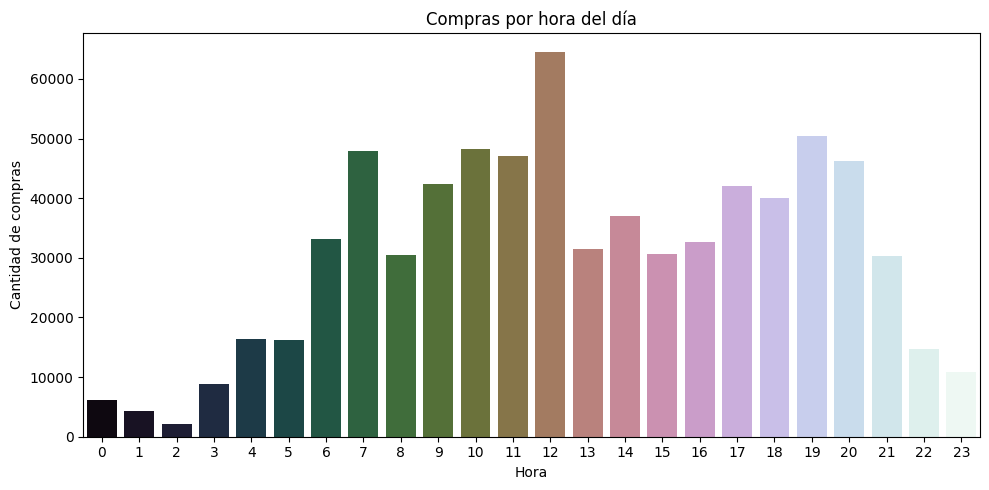

In [29]:
analizar_estacionalidad(df_merged)


# CONCLUSIONES
- las marcas con mayor volumen de compra son CND, ENTITY Y MATRIX.
- el titanium dioxide es el ingrediente mas frecuente en los productos mas vendidos.
- el precio promedio de la marca mas vendida es de 15$, mientras que orly es la marca con precio promedio mas bajo 12$ y joico es la marca con precio promedio mas alto 40$.
- las marcas que mayor ingreso total generan son las mismas con mayor volumen de compra CND, MATRIX y ENTITY. 
- la categoria que mayor ingreso genera es la de PRODUCTOS PARA LAS U√ëAS.
- Los 10 productos que son mayormente recomprados por los usuarios son: PURE PINK SCULTING POWDER, PURE WHITE SCULPTING POWDER, CREATIVE PLAY BASE COAT, CREATIVE PLAY NAIL LACQUER, BRISA PAINT LIQUID GEL, PERFECT COLOR SCULPTING POWDER, VINYLUX WEEKLU POLISH, SHELLAC COLOR COAT, BRISA SCULPTING GEL CREATIVE PLAY POLISH.
- los martes, miercoles y jueves los consumidores tienden a comprar mas, pero no hay mucha diferencia con los demas dias. 
- el horario mas fuerte para la compra es las 12hs, seguido por las 19 y 20hs

In [30]:
df_merged.to_csv('../DATA/OUTPUT/datos_unificados.csv', index=False)